# 0. Required dependencies
Same as the provided start_here file

In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook
%matplotlib inline

In [2]:
# dataset filepath constant
dataset_path = './vub-ml-project-2024-animal-classification/'
# where do you want to save your features and other outputs:
output_path = './vub-ml-project-2024-animal-classification/output/'

In [3]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

print(f"dataset_path_train: {dataset_path_train}")

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')
print(f"Creating path: {features_path}")

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

dataset_path_train: ./vub-ml-project-2024-animal-classification/train
Creating path: ./vub-ml-project-2024-animal-classification/output/features


# 1. Loading the data and the labels
First, we'll get the training labels. The train data is ordered in a way such that all images in a class are stored in a separate folder, thus we can simply get a string represenation of the labels by using the folder names.

In [4]:
path1 = os.getcwd()
path = dataset_path_train
print("Working Directory: ", path1, "Path: ", path)

folder_path1 = os.path.join(dataset_path_train,'*')
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))

label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]
print("Number of classes:",num_classes)
print("\nLabels: \n", label_strings)

Working Directory:  C:\Users\sojij\WPO\ML\PROJECT\starterskit Path:  ./vub-ml-project-2024-animal-classification/train
Number of classes: 12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


**Building dictionary of the filepath**
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [5]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

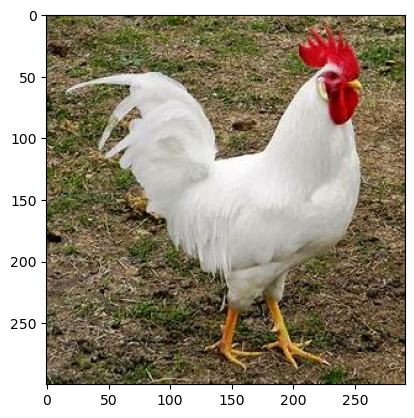

In [6]:
# load first image of class chicken using opencv:
image = cv2.imread(train_paths['chicken'][0])

# images can be plotted using matplotlib, but need to be converted from BGR to RGB
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

*Color Channels:* We'll plot each color channel individually to see how the different color channels are aligned in a numpy array which holds the image data:

Image shape: (300, 291, 3)


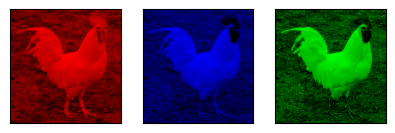

In [7]:
# blue, green and red channels are aligned along the third dimension of the returned numpy array
print('Image shape: {}'.format(image.shape))


# compute aspect ratio of image 
(height, width, nr_channels) = image.shape

aspect_ratio = width / float(height)

fig_height = 5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(fig_height * aspect_ratio, fig_height))
[ax.get_xaxis().set_visible(False) for ax in axes]
[ax.get_yaxis().set_visible(False) for ax in axes]
ax0, ax1, ax2 = axes

# extract blue, green and red channels from image
blue_channel = image[:, :, 0]
green_channel = image[:, :, 1]
red_channel = image[:, :, 2]

ax0.imshow(np.dstack([red_channel, np.zeros_like(blue_channel), np.zeros_like(blue_channel)]))
ax1.imshow(np.dstack([np.zeros_like(green_channel), np.zeros_like(green_channel), green_channel]))
ax2.imshow(np.dstack([np.zeros_like(red_channel), blue_channel, np.zeros_like(red_channel)]))

plt.show()

# 2. Looking at the data
Next, we plot the first 3 images of each class to get a first impression on what our data looks like.

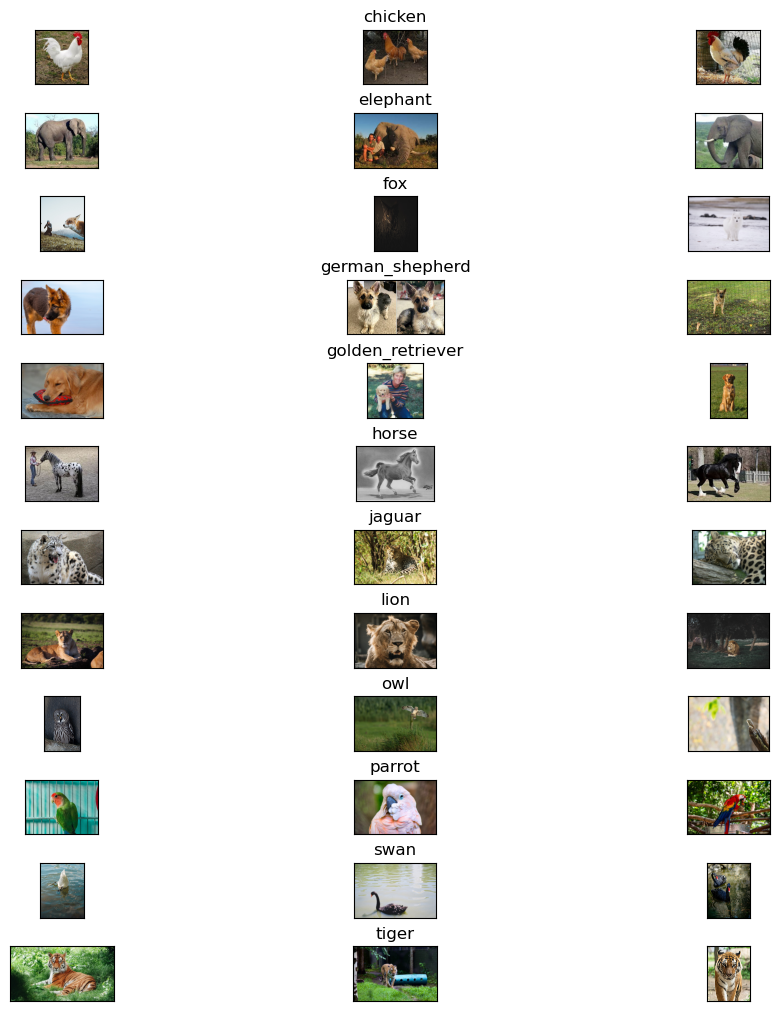

In [8]:
fig, axes = plt.subplots(nrows=num_classes, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:3]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

# 2. The Bag-Of-Visual-Words model
The concept of a **bag-of-words (BoW)** model originates from the field of Natural Language Processing (NLP). In NLP problems, the input is text. However, for a machine learning model, we need numerical features as input. One way to translate text to features is to use part of its natural structure: the grouping of characters into words. To construct a BoW-model, the steps are as follows (with possible fine-tunings for each step):

* Make a histogram of all the words in the text, strip out words that are not important (e.g., typos, words in another language, short words like 'the', 'an', 'of', ...) and possibly group similar words (e.g., conjugations of the same verb, synonyms ...).
* Keep the k most frequently occurring words (with k a hyperparameter).
* For each document, make a (k x 1) vector for which the i-th value corresponds to the number of times the i-th word occurs in that document.
Additionally, or as an alternative, we can also make binary vectors (only recording whether or not a word occurs in a document, not how frequently).
This gives long but sparse feature vectors that can be used in a machine learning model.

In a visual BoW, we do something similar for images. The problem is that there aren't any 'words' naturally available. Instead, we want to look for 'typical local structures' in the image (e.g. small significant areas or patches). Obviously, this shifts the problem to defining what 'typical patches' are. Luckily, there exist a range of feature extractors in image processing that detect those interesting patches. What this means exactly depends on the specific feature type, but these patches (or transformed representations of those) can be used to construct a dictionary for images. How this is done exactly is explained in more detail in the 'creating_vbow' notebook on this topic. It can be summarized as follows:

* We extract the chosen type of features for all the images in the training set (the maximal number is upper bounded by a hyperparameter).
* Accross this huge set of patches, we cluster similar patches together into a set number of classes (another hyperparameter, which sets the number of BoW features), and compute the 'average patch' for each cluster -- these are the visual 'words'.
* We then encode each image (from train set or test set) in a similar way to the BoW model: we assign each extracted patch to a cluster (word) and count how many times each cluster occurs in each image.


# 3. Using the provided image features
The dataset provided contains raw image features before the creation of clusters and the counting of the visual words. 
We simply load the extracted features from disk. They are stored as pickle files, which are just files serialized for python.

In [9]:
#Descriptor used: daisy
descriptor_desired = 'daisy'

start = time.time()
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

end = time.time()
print(f'Loading Train and Test features took {end - start:.2f} seconds. Descriptor used: {descriptor_desired}')

print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))


Loading Train and Test features took 18.39 seconds. Descriptor used: daisy
Number of encoded train images: 4042
Number of encoded test images: 4035


The next thing we need to do is to cluster the training features into the words that will construct our dictionary. 
Note that the number of categories (words) is a hyperparameter that should be optimised, ideally with grid search.

The functions we use below are implemented in the 'helpers' library. Our kind thanks go out to the authors of [https://github.com/flytxtds/scene-recognition](https://github.com/flytxtds/scene-recognition), from where this code has been adapted. 

The code below creates the desired encoded BoW feature vector.

In [10]:
# learn the codebook for the descriptor ('daisy') features from the training data
codebook_size = 1200
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)

C:\Users\sojij\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


training took 183.97308444976807 seconds


In [11]:
# encode all train and test images 
train_data = []
train_labels = []
test_data = []
start = time.time()
for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
end = time.time()
print(f'Encoding Train features took {end - start:.2f} seconds.')

start = time.time()
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)
end = time.time()
print(f'Encoding Test features took {end - start:.2f} seconds.')


Encoding Train features took 18.08 seconds.
Encoding Test features took 19.17 seconds.


Now that we have readily useable train and test data matrices, there is only one thing missing: our label vector still contains string representations of our labels, but in order to train a supervised classifier, we need the labels to be represented as integers of course. The <code>LabelEncoder</code> class of sklearn does exactly that.

In [12]:
# use a labelencoder to obtain numerical labels
label_encoder = sklearn.preprocessing.LabelEncoder()
print("\nLabels before calling label_encoder.fit: \n", label_strings)
label_encoder.fit(label_strings)
print(train_labels[:10])
print("len(train_labels):", len(train_labels))
train_labels = label_encoder.transform(train_labels)
print("len(train_labels):", len(train_labels))
print(train_labels[:10])


Labels before calling label_encoder.fit: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
len(train_labels): 4042
len(train_labels): 4042
[0 0 0 0 0 0 0 0 0 0]


We now have feature vectors with hopefully meaningful BOVW representations, as well as a train label vector in the right format. We are all set to start and train a supervised model on our data, do feature selection, model evaluation etc. 

# Preliminary Data analysis
There are 12 different classes in this supervised multiclass classification problem. We'll start with calculating number of images for each of the classes.

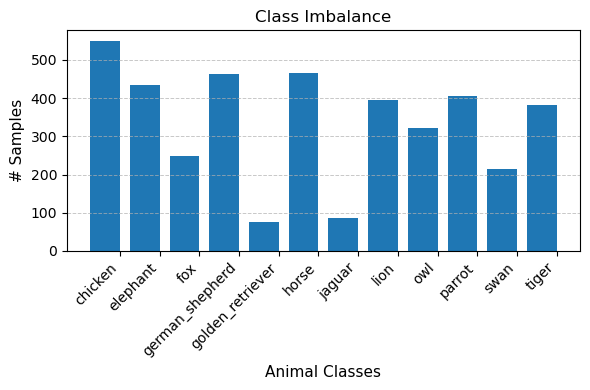

In [13]:
# calculate the number of training samples there are available for each Animal class
sample_size_dict = {key: len(value) for key, value in train_paths.items()}

x = sample_size_dict.keys()
y = sample_size_dict.values()
classes = x
sample_sizes = y

SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12    

figure, axes = plt.subplots(figsize=(6, 4))    
bar_width = 0.75 
class_index = np.arange(len(classes)) 
axes.bar(class_index, sample_sizes, bar_width)  # Use bar() for vertical bars
axes.set_xticks(class_index + bar_width / 2)
axes.set_xticklabels(classes, rotation=45, ha="right", fontsize=SMALL_SIZE)  # Rotate x-axis labels for better visibility
# Set grid lines
axes.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  # Add horizontal grid lines
axes.xaxis.grid(False)  # Disable vertical grid lines (optional)

axes.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
plt.title('Class Imbalance', fontsize=BIGGER_SIZE)
plt.ylabel('# Samples', fontsize=MEDIUM_SIZE)  # Swap x and y labels
plt.xlabel('Animal Classes', fontsize=MEDIUM_SIZE)  # Swap x and y labels
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join('class_balance.svg'), dpi=300, format='svg', bbox_inches='tight')


# Data analysis


In [14]:
# print the obtained feature vectors with their labels for a quick look
X = pd.DataFrame(train_data)
y = pd.DataFrame(train_labels)

# have a truncated look at the data
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.101404,0.050702,0.0,0.0,0.000000,0.0,0.0,0.050702
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.077382,0.0,...,0.0,0.0,0.000000,0.077382,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.093454,0.0,0.0,0.0,0.0,0.046727,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.035202,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.087706,0.0,0.0,0.000000


In [15]:
# print the obtained feature vectors with their labels for a quick look
data = np.c_[X, y]
print(pd.RangeIndex(start=1, stop=codebook_size+1, step=1))
columns = np.append(X.columns, ["target"])
pd_data = pd.DataFrame(data, columns=columns)

# have a truncated look at the data
pd_data.head()

RangeIndex(start=1, stop=1201, step=1)


,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,target
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.101404,0.050702,0.0,0.0,0.000000,0.0,0.0,0.050702,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.077382,0.0,...,0.0,0.000000,0.077382,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.093454,0.0,0.0,0.0,0.0,0.046727,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.035202,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.087706,0.0,0.0,0.000000,0.0


In [16]:
# missing values check
missing = 0
for col in pd_data.columns:
    if(pd_data[col].isnull().any()):
        print(col,'has missing values')
        missing = 1
if(missing==0):
    print('There are no missing values')

There are no missing values


#  Split into validation (QA) set(s) and test set(s)
As per requirement, the test data can not be used for optimization. So we need to split the training data a second time into a training set and a validation set (called 'QA' in this program).

This splitting could benefit from fine-tuning. See inline comment to check wether or not it has been fine-tuned. It is chosen to take into account the unbalance of the dataset given. More information in section: Fine-tuning the validation set

In [17]:
# As per requirement, the test data can not be used for optimization. So we need to split the training data a second time into a training set and a validation set.
test_fraction = 0.15
balanced = True

start = time.time()
if balanced:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)
else:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, random_state=0)
end = time.time()
print(f'Encoding Test features took {end - start:.2f} seconds.')


#validating the split
#print("Train labels: ", train_labels_split[:2])
#print("\nTrain data: \n", train_data_split[:2])

Encoding Test features took 0.01 seconds.


# Training the model
We can now start with training our model.

In [22]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score

# Step 1: Define Random Forest classifier
model=RandomForestClassifier(n_estimators=100)

# Step 2: Train the model
start = time.time()
model.fit(train_data_split, train_labels_split)
end = time.time()

# Step 3: Make predictions
predictions_train = model.predict(train_data_split)
predictions_probability_train = model.predict_proba(train_data_split)

predictions_test = model.predict(test_data_split)
predictions_probability_test = model.predict_proba(test_data_split)

# Step 4: Evaluate model performance
train_log_loss = log_loss(train_labels_split, predictions_probability_train)
test_log_loss = log_loss(test_labels_split, predictions_probability_test)  # Corrected this line

train_accuracy = accuracy_score(train_labels_split, predictions_train)
test_accuracy = accuracy_score(test_labels_split, predictions_test)

# Step 5: Output results
print('RandomForests Model took {:.2f} seconds'.format(end - start))
print("Train log_loss:", train_log_loss)
print("Test log_loss:", test_log_loss)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

RandomForests Model took 10.36 seconds
Train log_loss: 0.33436857311636325
Test log_loss: 1.6941756805442918
Train Accuracy: 1.0
Test Accuracy: 0.47775947281713343


# FINAL - Making a submission
Now use the test data on the trained model and call the helpers.writePredictionsToCsv function to write out predictions as a csv file ready to be submitted to the competition page.

In [23]:
# Check predictions_probability_test shape
print("Shape of predictions_train:", predictions_train.shape)
print("Shape of predictions_probability_train:", predictions_probability_train.shape)
print("Shape of predictions_test:", predictions_test.shape)
print("Shape of predictions_probability_test:", predictions_probability_test.shape)
print("len(predictions_train):", len(predictions_train))
print("len(predictions_probability_train):", len(predictions_probability_train))
print("len(predictions_test):", len(predictions_test))
print("len(predictions_probability_test):", len(predictions_probability_test))
print("len(train_paths):", len(train_paths))
print("len(test_paths):", len(test_paths))


# Do predictions on the actual test data
predictions_probability_final_test_data = model.predict_proba(test_data)

# Ensure predictions_probability_test matches the number of test paths
#if len(predictions_probability_test) != len(test_paths):
#    raise ValueError("Mismatch between number of predictions and test paths.")

# Build the submission file
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('prior_probas', 'csv'))

# Writing predictions to CSV
helpers.writePredictionsToCsv(predictions_probability_final_test_data, pred_file_path, label_strings)

print(f"Predictions written to {pred_file_path}")

Shape of predictions_train: (3435,)
Shape of predictions_probability_train: (3435, 12)
Shape of predictions_test: (607,)
Shape of predictions_probability_test: (607, 12)
len(predictions_train): 3435
len(predictions_probability_train): 3435
len(predictions_test): 607
len(predictions_probability_test): 607
len(train_paths): 12
len(test_paths): 4035
Predictions written to ./vub-ml-project-2024-animal-classification/output/predictions\prior_probas_20250115-232950.csv
